In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hairdata1/dreadlocks/image233.jpg
/kaggle/input/hairdata1/dreadlocks/images141.jpg
/kaggle/input/hairdata1/dreadlocks/fb8bbfb130a3ec23982a5a3a31b8f9a5.jpg
/kaggle/input/hairdata1/dreadlocks/image106.jpg
/kaggle/input/hairdata1/dreadlocks/image27.jpg
/kaggle/input/hairdata1/dreadlocks/images69.jpg
/kaggle/input/hairdata1/dreadlocks/image109.jpg
/kaggle/input/hairdata1/dreadlocks/19-long-hair-locs-with-square-parting-CEDQMZjJnZV.jpg
/kaggle/input/hairdata1/dreadlocks/image2.jpg
/kaggle/input/hairdata1/dreadlocks/image115.jpg
/kaggle/input/hairdata1/dreadlocks/image47.jpg
/kaggle/input/hairdata1/dreadlocks/image300.jpg
/kaggle/input/hairdata1/dreadlocks/image245.jpg
/kaggle/input/hairdata1/dreadlocks/image297.jpg
/kaggle/input/hairdata1/dreadlocks/1200px-Man_with_dreadlocks.jpg
/kaggle/input/hairdata1/dreadlocks/image146.jpg
/kaggle/input/hairdata1/dreadlocks/image343.jpg
/kaggle/input/hairdata1/dreadlocks/image40.jpg
/kaggle/input/hairdata1/dreadlocks/sheer-elegance-model-2

In [2]:
! pip install albumentations==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
import fastai
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
import albumentations as A
from sklearn.metrics import classification_report
import cv2
from pathlib import Path

 # Creates the directory if it doesn't exist


In [4]:
path = Path("/kaggle/input/hairdata1")  # Update with the exact dataset name in Kaggle
model_dir = Path("/kaggle/working/models")  # Save models in Kaggle's working directory
model_dir.mkdir(parents=True, exist_ok=True)


In [5]:
class AlbumentationsTransform(RandTransform):
    split_idx = 0
    order = 2

    def __init__(self, train_aug, valid_aug):
        self.train_aug = train_aug
        self.valid_aug = valid_aug

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        img_np = np.array(img)
        aug_img = self.train_aug(image=img_np)['image'] if self.idx == 0 else self.valid_aug(image=img_np)['image']
        return PILImage.create(aug_img)

def get_train_aug(sz):
    return A.Compose([
        A.RandomResizedCrop(height=sz, width=sz, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=cv2.INTER_LINEAR, p=1),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, interpolation=cv2.INTER_LINEAR, p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
    ])

def get_valid_aug(sz):
    return A.Compose([
        A.Resize(height=sz, width=sz, interpolation=cv2.INTER_LINEAR, p=1.0)
    ])

def get_dls(path, sz=224, bs=64):
    item_tfms = [Resize(sz), AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz))]
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]

    dls = ImageDataLoaders.from_folder(
        path, valid_pct=0.2, seed=42,
        item_tfms=item_tfms, batch_tfms=batch_tfms, bs=bs
    )
    return dls

print("Preparing data...")
dls = get_dls(path, sz=224, bs=64)


Preparing data...


In [6]:
def print_classification_report(learn):
    preds, targs = learn.get_preds(dl=learn.dls.valid)
    pred_classes = preds.argmax(dim=1)
    class_names = learn.dls.vocab
    print(classification_report(targs, pred_classes, target_names=class_names))

def train_model(model_name, arch, dls, epochs=10):
    print(f"\nTraining {model_name}...")

    learn = vision_learner(dls, arch, metrics=[accuracy], wd=1e-2,
                          cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=2),
                               SaveModelCallback(monitor='valid_loss')])

    learn.model_dir = model_dir.absolute()

    # Phase 1: Fine-tune
    print("="*50)
    print("Phase 1: Fine-tuning...")
    print("="*50)
    learn.fine_tune(epochs)

    # Phase 2: Train Unfrozen Model
    print("\n" + "="*50)
    print("Phase 2: Training with unfrozen layers...")
    print("="*50)
    learn.unfreeze()

    try:
        lr_results = learn.lr_find(suggest_funcs=(steep, valley))
        lr_min = lr_results[0] if isinstance(lr_results, tuple) else 1e-3
    except Exception as e:
        print(f"Warning: Failed to find learning rate. Using default 1e-3. Error: {e}")
        lr_min = 1e-3

    learn.fit_one_cycle(epochs, lr_min)

    # Evaluation
    print("\nGenerating evaluation metrics...")
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.plot_top_losses(10, nrows=2)

    print(f"\nClassification Report for {model_name}:")
    print_classification_report(learn)

    acc = learn.validate()[1] * 100  # Convert to percentage
  # Convert to percentage
    print(f"\nFinal Accuracy for {model_name}: {acc:.2f}%")

    # Save Model Only If Accuracy > 90%
    if acc > 90:
        model_path = model_dir / f'{model_name}.pkl'
        learn.export(model_path)
        print(f"Model saved as {model_path}")
        return learn
    else:
        print(f"Model {model_name} not saved (Accuracy < 90%)")
        return None



Starting training for resnet50

Training hair-resnet50...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]


Phase 1: Fine-tuning...


epoch,train_loss,valid_loss,accuracy,time
0,1.432116,0.768142,0.730818,00:25


Better model found at epoch 0 with valid_loss value: 0.7681415677070618.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,1.008641,0.483918,0.823899,00:24
1,0.881768,0.491793,0.822641,00:24
2,0.765540,0.447661,0.845283,00:24
3,0.659176,0.357297,0.867925,00:24
4,0.570860,0.343009,0.880503,00:23
5,0.510745,0.302878,0.883019,00:24
6,0.468724,0.273790,0.896855,00:23
7,0.415400,0.272410,0.903145,00:24
8,0.391102,0.270556,0.901887,00:24
9,0.369439,0.276235,0.901887,00:24


Better model found at epoch 0 with valid_loss value: 0.4839180111885071.
Better model found at epoch 2 with valid_loss value: 0.4476613998413086.
Better model found at epoch 3 with valid_loss value: 0.3572966456413269.
Better model found at epoch 4 with valid_loss value: 0.3430090844631195.
Better model found at epoch 5 with valid_loss value: 0.30287793278694153.
Better model found at epoch 6 with valid_loss value: 0.2737902104854584.
Better model found at epoch 7 with valid_loss value: 0.272409588098526.
Better model found at epoch 8 with valid_loss value: 0.27055636048316956.

Phase 2: Training with unfrozen layers...


epoch,train_loss,valid_loss,accuracy,time
0,0.351176,0.259507,0.903145,00:24
1,0.363207,0.275557,0.905660,00:24
2,0.350111,0.273854,0.910692,00:24


Better model found at epoch 0 with valid_loss value: 0.25950685143470764.
No improvement since epoch 0: early stopping

Generating evaluation metrics...



Classification Report for hair-resnet50:


              precision    recall  f1-score   support

    Straight       0.92      0.92      0.92       195
        Wavy       0.82      0.81      0.82       126
       curly       0.86      0.92      0.89       186
  dreadlocks       0.97      0.99      0.98       193
       kinky       0.91      0.77      0.83        95

    accuracy                           0.90       795
   macro avg       0.90      0.88      0.89       795
weighted avg       0.90      0.90      0.90       795



Better model found at epoch 0 with valid_loss value: 0.9031446576118469.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs


Final Accuracy for hair-resnet50: 90.31%
Model saved as /kaggle/working/models/hair-resnet50.pkl

Completed training resnet50

Starting training for vgg16_bn

Training hair-vgg16...


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 236MB/s]


Phase 1: Fine-tuning...


epoch,train_loss,valid_loss,accuracy,time
0,1.629874,0.757469,0.739623,00:24


Better model found at epoch 0 with valid_loss value: 0.757468581199646.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,1.011645,0.559772,0.808805,00:30
1,0.854744,0.439193,0.835220,00:30
2,0.776831,0.447422,0.857862,00:30
3,0.681021,0.369788,0.869182,00:30
4,0.596506,0.291274,0.890566,00:30
5,0.552809,0.280662,0.899371,00:30
6,0.501776,0.272208,0.895597,00:30
7,0.464302,0.248773,0.906918,00:30
8,0.434289,0.237370,0.909434,00:30
9,0.430509,0.241853,0.908176,00:31


Better model found at epoch 0 with valid_loss value: 0.5597721338272095.
Better model found at epoch 1 with valid_loss value: 0.43919262290000916.
Better model found at epoch 3 with valid_loss value: 0.3697880208492279.
Better model found at epoch 4 with valid_loss value: 0.2912740409374237.
Better model found at epoch 5 with valid_loss value: 0.280661940574646.
Better model found at epoch 6 with valid_loss value: 0.2722075581550598.
Better model found at epoch 7 with valid_loss value: 0.24877287447452545.
Better model found at epoch 8 with valid_loss value: 0.2373703420162201.

Phase 2: Training with unfrozen layers...


epoch,train_loss,valid_loss,accuracy,time
0,0.416175,0.240840,0.915723,00:30
1,0.409913,0.242402,0.906918,00:30
2,0.398944,0.241228,0.905660,00:31


Better model found at epoch 0 with valid_loss value: 0.2408401519060135.
No improvement since epoch 0: early stopping

Generating evaluation metrics...



Classification Report for hair-vgg16:


              precision    recall  f1-score   support

    Straight       0.88      0.94      0.91       195
        Wavy       0.89      0.83      0.86       126
       curly       0.91      0.92      0.91       186
  dreadlocks       0.98      0.97      0.98       193
       kinky       0.90      0.85      0.88        95

    accuracy                           0.92       795
   macro avg       0.91      0.90      0.91       795
weighted avg       0.92      0.92      0.92       795



Better model found at epoch 0 with valid_loss value: 0.9157232642173767.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs


Final Accuracy for hair-vgg16: 91.57%
Model saved as /kaggle/working/models/hair-vgg16.pkl

Completed training vgg16_bn

Starting training for convnext_tiny

Training hair-convnext-tiny...


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 205MB/s]


Phase 1: Fine-tuning...


epoch,train_loss,valid_loss,accuracy,time
0,1.386452,0.570651,0.783648,00:35


Better model found at epoch 0 with valid_loss value: 0.5706512928009033.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.813275,0.441497,0.835220,01:18
1,0.753601,0.409033,0.844025,01:17
2,0.702661,0.338513,0.876730,01:17
3,0.624902,0.282707,0.899371,01:17
4,0.550366,0.297583,0.884277,01:17
5,0.520332,0.251048,0.908176,01:17
6,0.484800,0.243137,0.910692,01:18
7,0.450523,0.239038,0.910692,01:17
8,0.432479,0.235772,0.916981,01:18
9,0.424328,0.240138,0.916981,01:18


Better model found at epoch 0 with valid_loss value: 0.44149652123451233.
Better model found at epoch 1 with valid_loss value: 0.409032940864563.
Better model found at epoch 2 with valid_loss value: 0.33851319551467896.
Better model found at epoch 3 with valid_loss value: 0.2827069163322449.
Better model found at epoch 5 with valid_loss value: 0.25104787945747375.
Better model found at epoch 6 with valid_loss value: 0.24313749372959137.
Better model found at epoch 7 with valid_loss value: 0.23903803527355194.
Better model found at epoch 8 with valid_loss value: 0.23577183485031128.

Phase 2: Training with unfrozen layers...


epoch,train_loss,valid_loss,accuracy,time
0,0.429063,0.237325,0.910692,01:18
1,0.417229,0.236896,0.918239,01:18
2,0.422816,0.226915,0.919497,01:18
3,0.419818,0.225666,0.916981,01:19
4,0.404089,0.225835,0.916981,01:18
5,0.409835,0.221193,0.922013,01:18
6,0.400745,0.222513,0.918239,01:18
7,0.391477,0.219198,0.920755,01:18
8,0.409070,0.220229,0.915723,01:18
9,0.392707,0.222766,0.919497,01:18


Better model found at epoch 0 with valid_loss value: 0.23732469975948334.
Better model found at epoch 1 with valid_loss value: 0.23689590394496918.
Better model found at epoch 2 with valid_loss value: 0.22691494226455688.
Better model found at epoch 3 with valid_loss value: 0.22566570341587067.
Better model found at epoch 5 with valid_loss value: 0.22119273245334625.
Better model found at epoch 7 with valid_loss value: 0.2191975712776184.
No improvement since epoch 7: early stopping

Generating evaluation metrics...



Classification Report for hair-convnext-tiny:


              precision    recall  f1-score   support

    Straight       0.92      0.96      0.94       195
        Wavy       0.87      0.82      0.84       126
       curly       0.89      0.95      0.92       186
  dreadlocks       0.98      0.98      0.98       193
       kinky       0.94      0.80      0.86        95

    accuracy                           0.92       795
   macro avg       0.92      0.90      0.91       795
weighted avg       0.92      0.92      0.92       795



Better model found at epoch 0 with valid_loss value: 0.9207547307014465.


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs


Final Accuracy for hair-convnext-tiny: 92.08%
Model saved as /kaggle/working/models/hair-convnext-tiny.pkl

Completed training convnext_tiny

Training completed for all models!


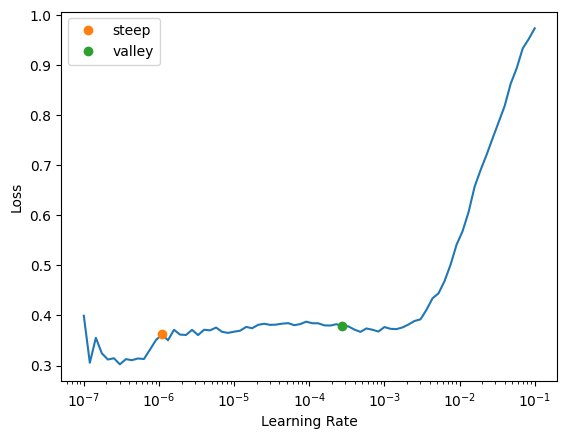

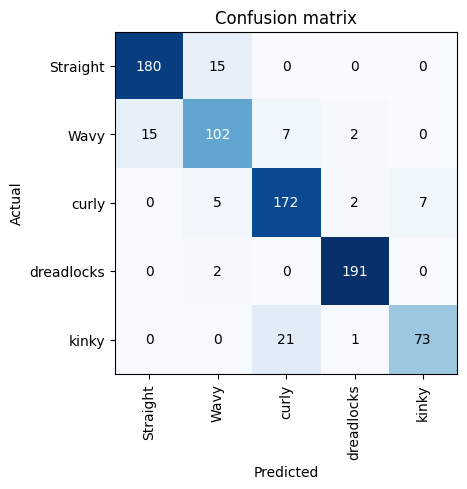

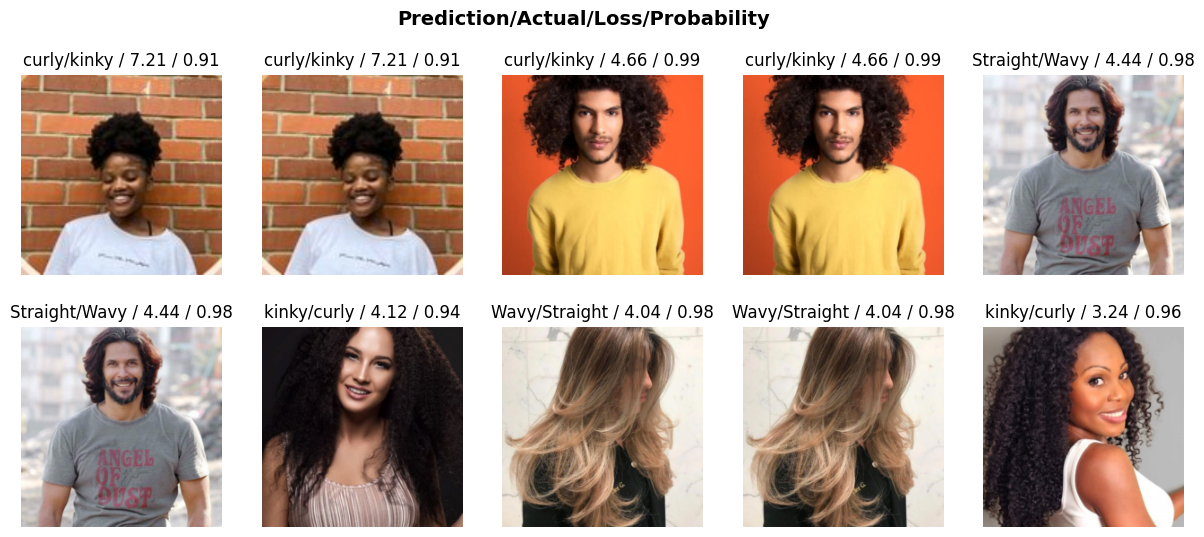

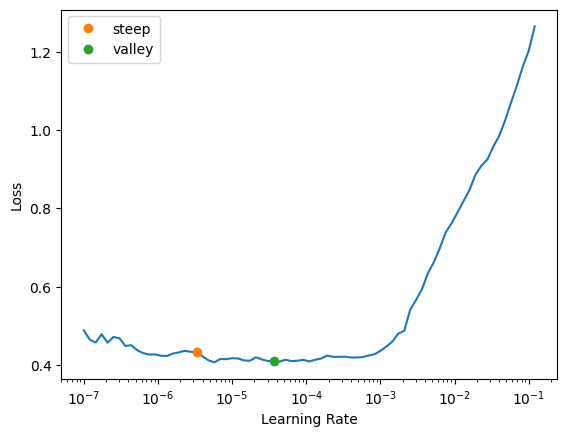

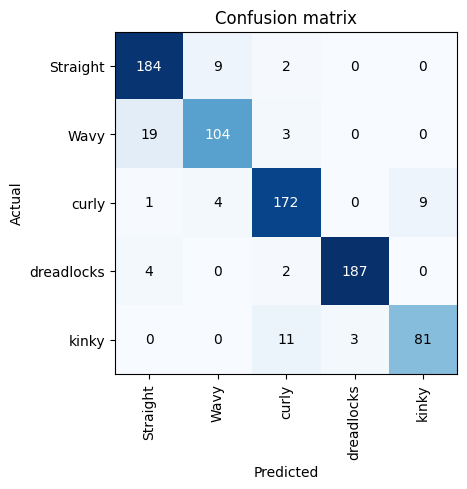

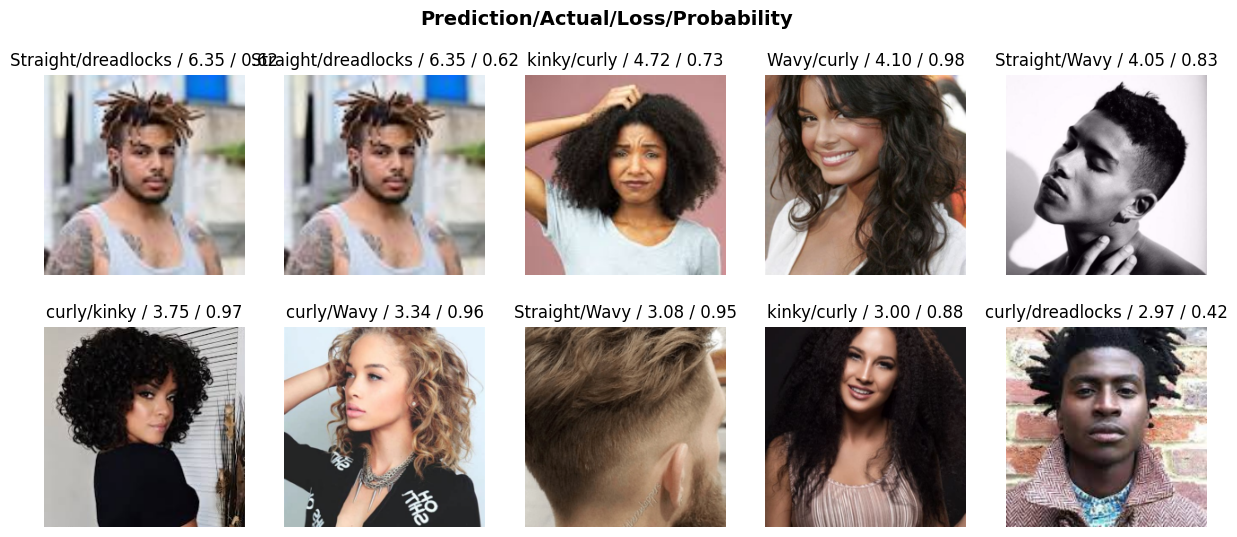

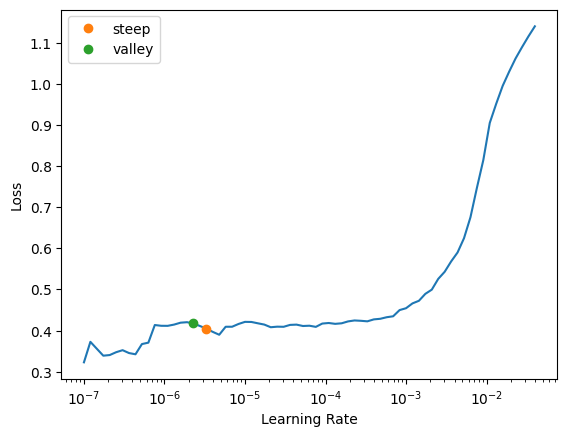

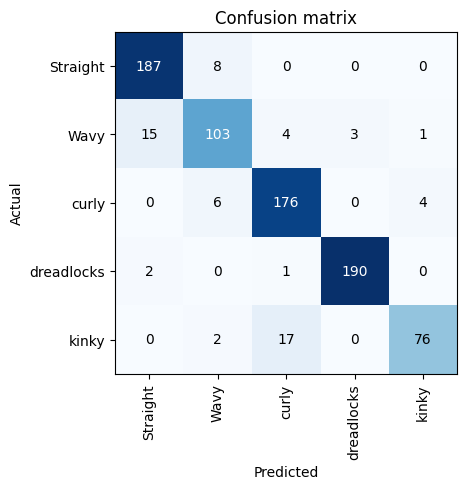

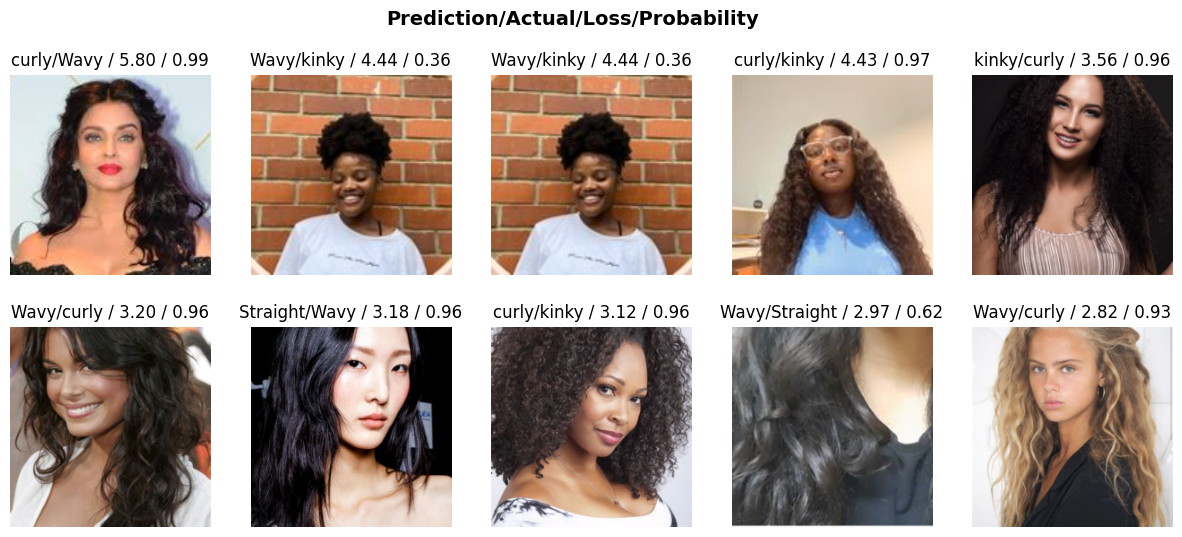

In [7]:
models_to_train = [
    ("resnet50", resnet50, "hair-resnet50"),
    ("vgg16_bn", vgg16_bn, "hair-vgg16"),
    ("convnext_tiny", convnext_tiny, "hair-convnext-tiny")
]

trained_models = {}

for model_desc, arch, save_name in models_to_train:
    print(f"\n{'='*50}")
    print(f"Starting training for {model_desc}")
    print(f"{'='*50}")

    model = train_model(save_name, arch, dls)
    if model:
        trained_models[model_desc] = model
        print(f"\nCompleted training {model_desc}")
    else:
        print(f"\nSkipping {model_desc} for ensemble")

print("\nTraining completed for all models!")


In [8]:
def ensemble_predict(models, dls):
    preds_list = []

    for model_name, learn in models.items():
        preds, _ = learn.get_preds(dl=dls.valid)
        preds_list.append(preds)

    avg_preds = torch.mean(torch.stack(preds_list), dim=0)
    final_pred_classes = avg_preds.argmax(dim=1)

    return final_pred_classes

if trained_models:
    print("\nGenerating Ensemble Predictions...")
    ensemble_preds = ensemble_predict(trained_models, dls)

    # Compute Classification Report
    _, targs = list(trained_models.values())[0].get_preds(dl=dls.valid)
    class_names = dls.vocab
    print("\nEnsemble Model Classification Report:")
    print(classification_report(targs, ensemble_preds, target_names=class_names))
else:
    print("\nNo models were trained with accuracy > 90%, skipping ensemble.")



Generating Ensemble Predictions...



Ensemble Model Classification Report:
              precision    recall  f1-score   support

    Straight       0.92      0.94      0.93       195
        Wavy       0.88      0.85      0.86       126
       curly       0.91      0.93      0.92       186
  dreadlocks       1.00      1.00      1.00       193
       kinky       0.90      0.86      0.88        95

    accuracy                           0.93       795
   macro avg       0.92      0.92      0.92       795
weighted avg       0.93      0.93      0.93       795



In [ ]:
import cv2
import torch
import fastai.vision.all as fv
from PIL import Image
import torchvision.transforms as transforms

# Load the FastAI model
model_path = "Models/hair-vgg16.pkl"
learn = fv.load_learner(model_path)

# Define transformation (FastAI handles its own preprocessing)
class_labels = ["Straight", "Wavy", "Curly", "Dreadlocks", "Kinky"]

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break

    # Convert OpenCV frame to PIL Image
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img)

    # Run inference with FastAI
    pred, pred_idx, probs = learn.predict(img_pil)
    predicted_label = str(pred)

    # Display prediction on webcam feed
    cv2.putText(frame, f"Prediction: {predicted_label}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Webcam - Hair Type Classification", frame)

    # Check if the window is closed
    if cv2.getWindowProperty("Webcam - Hair Type Classification", cv2.WND_PROP_VISIBLE) < 1:
        print("Window closed, stopping camera...")
        break

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
